In [ ]:
!pip install tldextract joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.6 MB/s eta 0:00:00


# Import necessary libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import re
from urllib.parse import urlparse
import tldextract
import joblib
import requests

# Load and Explore Dataset


In [70]:
df = pd.read_csv("dataset_phishing.csv")
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [71]:
print(f"Dataset dimensions: {df.shape}")

Dataset dimensions: (11430, 89)


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [73]:
df.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,...,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,0.293176,...,0.124759,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,0.998317,...,0.330460,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,33.000000,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,84.000000,972.250000,0.000000e+00,0.000000,0.000000,1.000000
50%,47.000000,19.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,242.000000,3993.000000,1.651000e+03,0.000000,1.000000,3.000000
75%,71.000000,24.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,1.000000,1.000000,0.000000,449.000000,7026.750000,3.738455e+05,0.000000,1.000000,5.000000
max,1641.000000,214.000000,1.000000,24.000000,43.000000,4.000000,3.000000,19.000000,0.0,19.000000,...,1.000000,1.000000,1.000000,1.000000,29829.000000,12874.000000,1.076799e+07,1.000000,1.000000,10.000000


# Exploratory Data Analysis

In [74]:
missing_values = df.isnull().sum()
print(f"Total missing values: {missing_values.sum()}")
missing_values[missing_values > 0]

Total missing values: 0


,0


Class distribution:


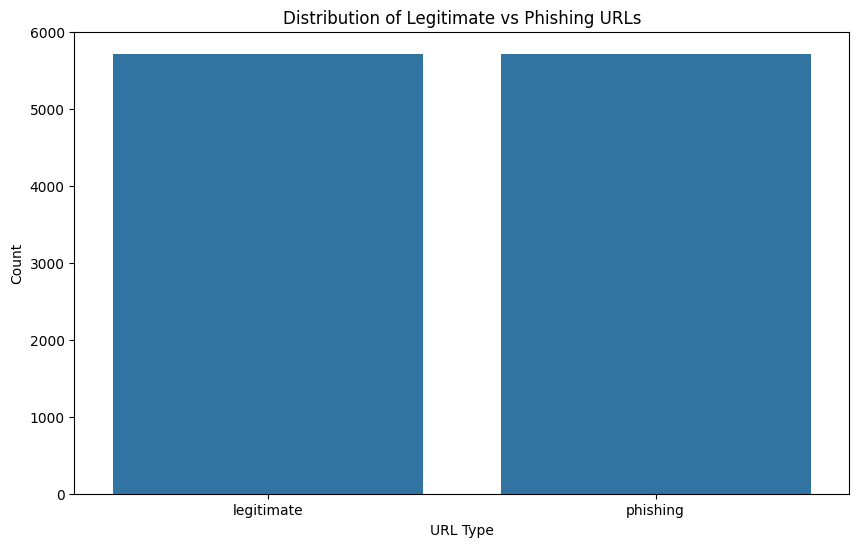

In [75]:
status_counts = df['status'].value_counts()
print("Class distribution:")
status_counts

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='status', data=df)
plt.title('Distribution of Legitimate vs Phishing URLs')
plt.xlabel('URL Type')
plt.ylabel('Count')
plt.show()

In [76]:
X = df.drop(['url', 'status'], axis=1)
y = df['status'].map({'phishing': 1, 'legitimate': 0})

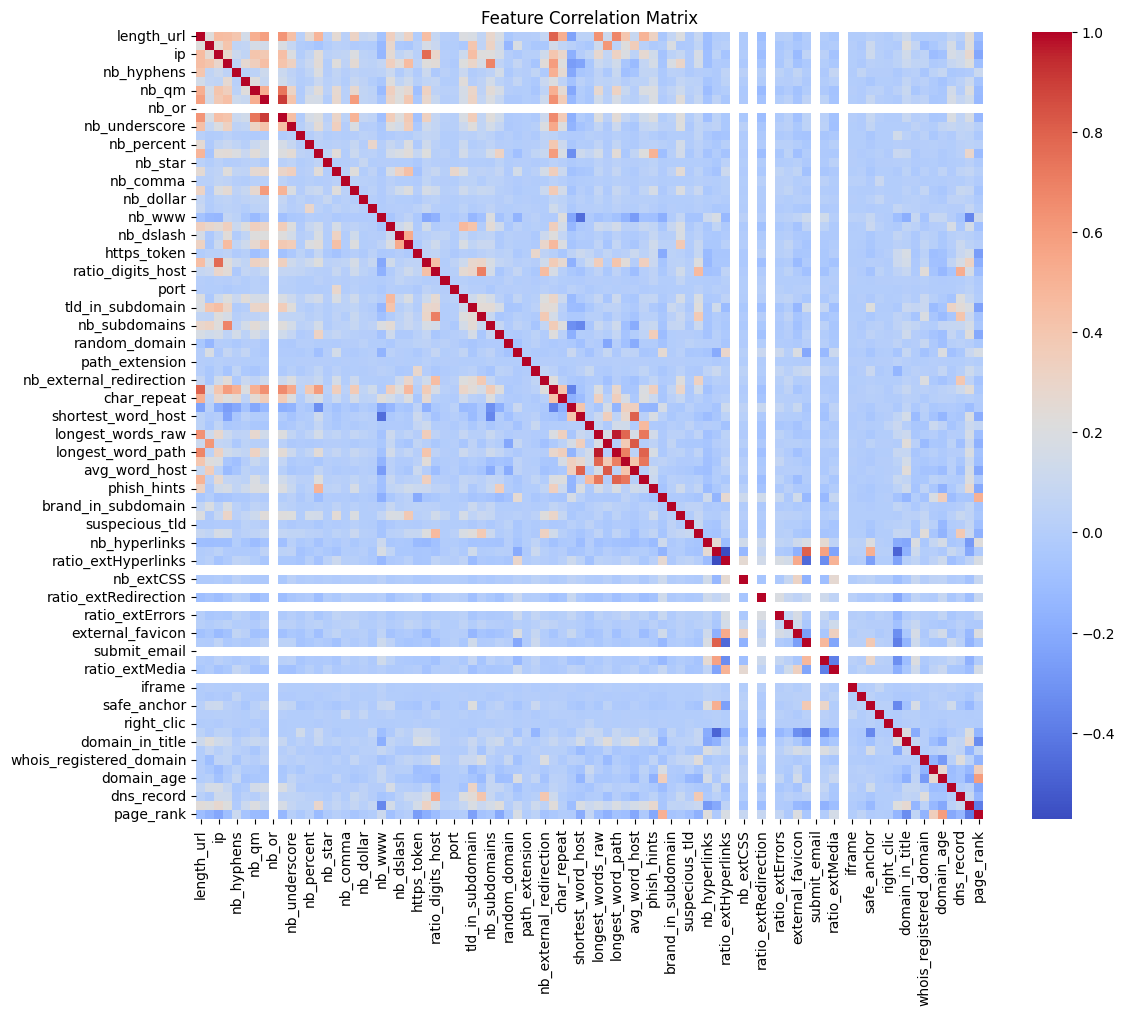

In [77]:
plt.figure(figsize=(12, 10))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Split data

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (9144, 87)
Test set size: (2286, 87)


## Scale features


In [79]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

feature_names = X.columns.tolist()

# Model building

In [80]:
input_dim = X_train.shape[1]
model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model summary:")
model.summary()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


Model summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 128)                 │          11,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,529 (88.00 KB)

 Trainable params: 22,081 (86.25 KB)

 Non-trainable params: 448 (1.75 KB)

# Model Training

In [81]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7651 - loss: 0.4836 - val_accuracy: 0.9479 - val_loss: 0.1657
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9258 - loss: 0.2035 - val_accuracy: 0.9558 - val_loss: 0.1238
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9343 - loss: 0.1745 - val_accuracy: 0.9598 - val_loss: 0.1135
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9340 - loss: 0.1741 - val_accuracy: 0.9637 - val_loss: 0.1055
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9401 - loss: 0.1635 - val_accuracy: 0.9659 - val_loss: 0.1006
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9477 - loss: 0.1412 - val_accuracy: 0.9654 - val_loss: 0.0976
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9491 - loss: 0.1366 - val_accuracy: 0.9676 - val_loss: 0.0965
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9489 - loss: 0.1432 - val_accuracy: 0.

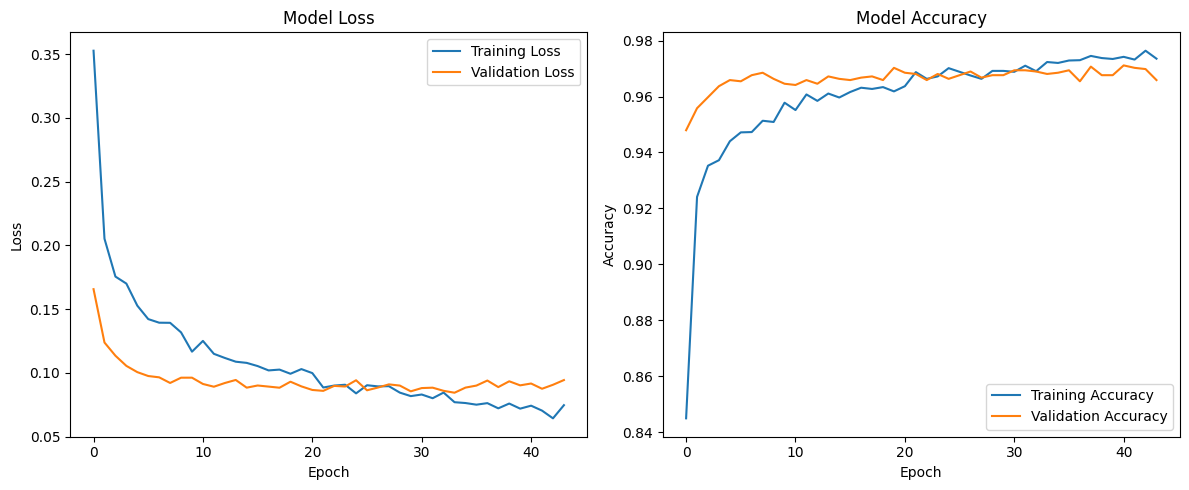

In [82]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9724 - loss: 0.0806
Test Loss: 0.0845
Test Accuracy: 0.9681
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


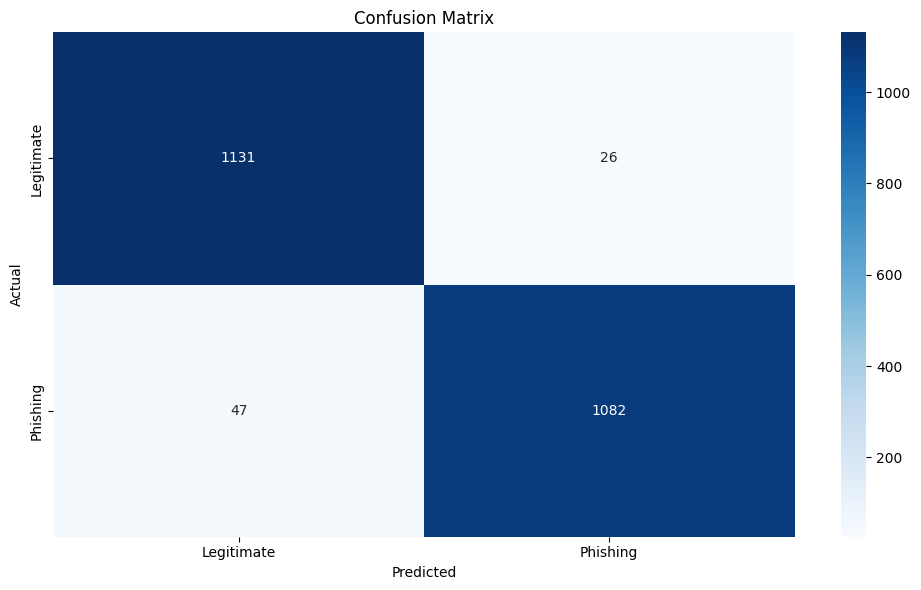

In [83]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_prob = model.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [84]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.96      0.98      0.97      1157
    Phishing       0.98      0.96      0.97      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



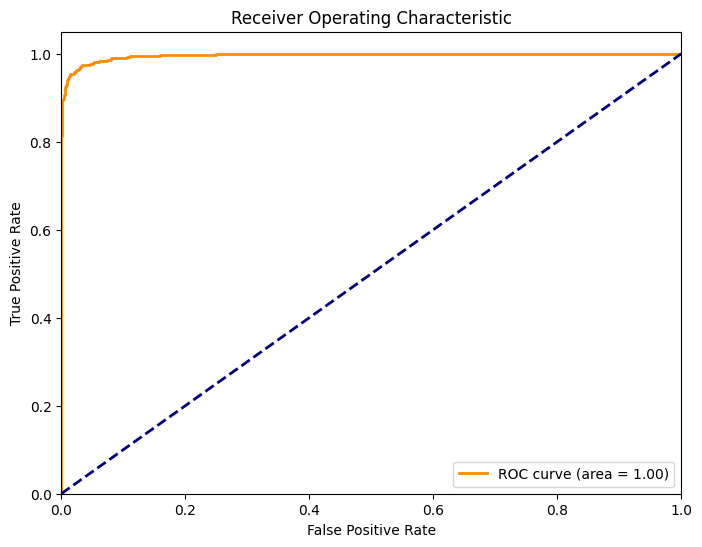

In [85]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Saving the Model

In [86]:
model.save('phishing_model.keras')
joblib.dump((scaler, feature_names), 'scaler_features.pkl')

print("Model and scaler saved successfully")

Model and scaler saved successfully


# URL Feature Extraction

Extract features from a URL

In [87]:
def extract_url_features(url, feature_names):
    features = {}

    try:
        features['length_url'] = len(url)

        # Parse the URL
        parsed_url = urlparse(url)
        domain_info = tldextract.extract(url)
        domain = domain_info.domain
        subdomain = domain_info.subdomain
        tld = domain_info.suffix

        # URL structure features
        features['length_hostname'] = len(parsed_url.netloc)
        features['length_path'] = len(parsed_url.path)
        features['length_query'] = len(parsed_url.query)
        features['length_fragment'] = len(parsed_url.fragment)
        features['length_domain'] = len(domain)
        features['length_subdomain'] = len(subdomain)
        features['length_tld'] = len(tld)

        # Flag features
        features['ip'] = 1 if re.match(r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$', domain) else 0
        features['https_token'] = 1 if parsed_url.scheme == 'https' else 0
        features['has_subdomain'] = 1 if subdomain else 0
        features['has_port'] = 1 if parsed_url.port else 0
        features['shortening_service'] = 1 if any(x in parsed_url.netloc for x in ['bit.ly', 'goo.gl', 't.co', 'tinyurl', 'is.gd']) else 0
        features['prefix_suffix'] = 1 if '-' in parsed_url.netloc else 0

        # Count features
        features['count_dots'] = url.count('.')
        features['count_hyphens'] = url.count('-')
        features['count_underscores'] = url.count('_')
        features['count_slashes'] = url.count('/')
        features['count_at'] = url.count('@')
        features['count_questionmark'] = url.count('?')
        features['count_equal'] = url.count('=')
        features['count_tilde'] = url.count('~')
        features['count_percent'] = url.count('%')
        features['count_ampersand'] = url.count('&')
        features['count_exclamation'] = url.count('!')
        features['count_space'] = url.count(' ')
        features['count_dollar'] = url.count('$')
        features['count_star'] = url.count('*')
        features['count_subdomains'] = subdomain.count('.') + 1 if subdomain else 0
        features['count_digits'] = sum(c.isdigit() for c in url)
        features['count_letters'] = sum(c.isalpha() for c in url)
        features['count_parameters'] = parsed_url.query.count('&') + 1 if parsed_url.query else 0

        # Ratio features
        url_length = len(url)
        if url_length > 0:
            features['ratio_digits'] = features['count_digits'] / url_length
            features['ratio_letters'] = features['count_letters'] / url_length
        else:
            features['ratio_digits'] = 0
            features['ratio_letters'] = 0

        features['has_https'] = 1 if url.startswith('https://') else 0
        features['has_http'] = 1 if url.startswith('http://') else 0
        features['has_www'] = 1 if parsed_url.netloc.startswith('www.') else 0
        features['has_digits_in_domain'] = 1 if any(c.isdigit() for c in domain) else 0

        result = {feature: 0 for feature in feature_names}
        result.update({k: v for k, v in features.items() if k in feature_names})

        return result

    except Exception as e:
        print(f"Error extracting features for URL {url}: {str(e)}")
        return {feature: 0 for feature in feature_names}


Predict whether a URL is legitimate or phishing

In [88]:
def predict_url(url, model, scaler, feature_names):

    features = extract_url_features(url, feature_names)
    features_df = pd.DataFrame([features])

    features_df = features_df[feature_names]

    features_scaled = scaler.transform(features_df)

    probability = model.predict(features_scaled)[0][0]
    prediction = "phishing" if probability > 0.7 else "legitimate"
    confidence = max(probability, 1-probability) * 100

    return {
        "url": url,
        "prediction": prediction,
        "probability": float(probability),
        "confidence": f"{confidence:.2f}%"
    }

Function to check user-provided URLs

In [91]:
def check_user_urls():
    print("Enter URLs to check (one per line). Enter 'done' when finished:")
    urls = []
    while True:
        url = input()
        if url.lower() == 'done':
            break
        if url.strip():
            urls.append(url.strip())

    if not urls:
        print("No URLs provided.")
        return

    print("\nAnalyzing URLs...")


    model = load_model('phishing_model.keras')
    scaler, feature_names = joblib.load('scaler_features.pkl')

    for url in urls:
        result = predict_url(url, model, scaler, feature_names)
        print(f"\nURL: {result['url']}")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']}")
        print("-" * 50)


# Main Program

In [92]:
def main():
    print("URL Phishing Detection System")
    print("=" * 30)

    while True:
        print("\nOptions:")
        print("1. Check sample URLs")
        print("2. Check your own URLs")
        print("3. Exit")

        choice = input("\nEnter your choice (1-3): ")

        if choice == '1':
            model = load_model('phishing_model.keras')
            scaler, feature_names = joblib.load('scaler_features.pkl')

            sample_urls = [
                "https://www.google.com",
                "https://www.amazon.com",
                "https://github.com",
                "http://amaz0n-secure.com-findpackage.info",
                "http://paypal-secure.epizy.com",
                "http://signin.ebay-account.com.securelogin.net"
            ]

            # Display results for sample URLs
            print("\nAnalyzing sample URLs...")
            for url in sample_urls:
                result = predict_url(url, model, scaler, feature_names)
                print(f"\nURL: {result['url']}")
                print(f"Prediction: {result['prediction']}")
                print(f"Confidence: {result['confidence']}")
                print("-" * 50)

        elif choice == '2':
            check_user_urls()

        elif choice == '3':
            print("Closing Program...!")
            break

        else:
            print("Invalid choice. Please enter 1, 2, or 3.")

if __name__ == "__main__":
    main()

URL Phishing Detection System

Options:
1. Check sample URLs
2. Check your own URLs
3. Exit

Enter your choice (1-3): 1

Analyzing sample URLs...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step

URL: https://www.google.com
Prediction: legitimate
Confidence: 63.52%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

URL: https://www.amazon.com
Prediction: legitimate
Confidence: 63.52%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

URL: https://github.com
Prediction: legitimate
Confidence: 68.39%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

URL: http://amaz0n-secure.com-findpackage.info
Prediction: phishing
Confidence: 94.64%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

URL: http://paypal-secure.epizy.com
Prediction: phishing
Confidence: 79.70%
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/s

### Test:
* https://www.google.com
* https://www.amazon.com
* https://www.microsoft.com
* https://www.facebook.com
* https://www.apple.com
* http://amaz0n-secure.com-findpackage.info
* http://paypal-secure.epizy.com
* http://signin.ebay-account.com.securelogin.net
* http://appleid.apple.com.signin-appleid.tv
* http://bit.ly/2JhYLEy
* https://www.youtube.com/watch?v=7q8Uw3rmXyE&t=165s
* https://claude.ai/chat/5c8ae569-787e-4c10-a7ba-6f6fd20ac274
* http://activate.facebook.fblogins.net/88adbao798283o8298398?login.asp
* https://github.com/Malvericus/ScamSentry/blob/main/Phase1/scam_detection.ipynb"

